# Analyzing and comparing deep neural networks

Comparing latent dimensions of representations and weights

TODO

This notebook shows how to meaningfully compare activations and weights
of two networks with different random initial conditions. It uses two
architectures: a small MLP and a small CNN both trained on CIFAR-10.

It allows one to reproduce some of the analysis of the rainbow paper in
a toy setting: - Compute activation and weight covariance spectra - Show
that a subset of low-rank eigenvectors (of weights/activations)
contribute to the performance - Align two networks together - Show that
two networks learn similar weight covariances after alignment - Generate
a new network from the ensemble of networks with similar performance

Note that the reduced size of the networks lead to low accuracies of the
base models. Similarly, the precision of the “rainbow” analysis would be
improved by considering wider networks.

Also, contrary to learned scattering networks, the networks here learn
spatial filters (which are not well-modeled with a Gaussian
distribution), have a ReLU non-linearity rather than complex modulus
(the asymmetry of ReLU implies that one should probably consider
non-zero-mean weight distributions), and do not have batch normalization
layers (which leads to reduced alignment and clipping performance).

In [1]:
# TODO uncomment before final packaging
# %pip install git+https://github.com/BonnerLab/ccn-tutorial.git

In [2]:
import torch
from torch import nn
import torch.utils.data.dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
from matplotlib import pyplot as plt

In [3]:
import time
from tqdm.notebook import tqdm
import copy

import torch
from torch import nn
import torch.utils.data.dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_datasets():
    """Returns train and validation datasets."""
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    data_transforms = [
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
        transforms.Grayscale(),
    ]

    dataset_class = datasets.CIFAR10

    def get_dataset(train: bool):  # Returns the train or validation dataset.
        root = "./data"
        kwargs = dict(
            root=root,
            transform=transforms.Compose(data_transforms),
            train=train,
            download=True,
        )
        dataset = dataset_class(**kwargs)
        return dataset

    train_dataset = get_dataset(train=True)
    val_dataset = get_dataset(train=False)
    return train_dataset, val_dataset


def get_dataloaders(batch_size):
    """Returns train and validation dataloaders."""
    train_dataset, val_dataset = get_datasets()

    def get_dataloader(dataset, shuffle):
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=0,
            pin_memory=True,
        )

    train_loader = get_dataloader(train_dataset, shuffle=True)
    val_loader = get_dataloader(val_dataset, shuffle=False)
    return train_loader, val_loader


def initialize_mlp_model(dims):
    """Create a simple MLP model.
    :param dims: list of dimensions of each layer, should begin with dimension of input and end with number of classes.
    :return: Sequential MLP model
    """
    layers = [torch.nn.Flatten()]
    for i in range(len(dims) - 1):
        layers.append(nn.Linear(dims[i], dims[i + 1], bias=False))
        if i < len(dims) - 2:
            layers.append(nn.ReLU())
    model = nn.Sequential(*layers)
    return model


def initialize_cnn_model(
    channels, spatial_size=32, kernel_size=5, stride=2, num_classes=10
):
    """Create a simple CNN model.
    :param channels: list of channels of each convolutional layer, should begin with number of channels of input.
    :return Sequential CNN model
    """
    layers = []
    for i in range(len(channels) - 1):
        layers.append(
            nn.Conv2d(channels[i], channels[i + 1], kernel_size=5, stride=2, bias=False)
        )
        spatial_size = ceil_div(spatial_size - kernel_size + 1, stride)
        layers.append(nn.ReLU())

    layers.extend(
        [
            nn.Flatten(),
            nn.Linear(channels[-1] * spatial_size**2, num_classes, bias=False),
        ]
    )
    model = nn.Sequential(*layers)
    return model


def ceil_div(a: int, b: int) -> int:
    """Return ceil(a / b)."""
    return a // b + (a % b > 0)


def train_model(model, train_loader, val_loader, lr=0.01, momentum=0.9, num_epochs=5):
    """Simple training of a model with SGD."""
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss_fn = nn.CrossEntropyLoss()

    epoch = 0
    model.to(DEVICE)
    while True:
        # Evaluate on validation set.
        one_epoch(
            loader=val_loader,
            model=model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            epoch=epoch,
            is_training=False,
        )

        # Stop if we are at the last epoch.
        if epoch == num_epochs:
            break

        # Train for one epoch (now epoch counts the current training epoch).
        epoch += 1
        one_epoch(
            loader=train_loader,
            model=model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            epoch=epoch,
            is_training=True,
        )

    # Ensure evaluation mode and disable gradients before returning trained model.
    model.eval()
    for param in model.parameters():
        param.requires_grad = False
    return model


def one_epoch(loader, model, loss_fn, optimizer, epoch, is_training):
    """Run one train or validation epoch on the model.
    :param loader: dataloader to use
    :param model: model to train or evaluate
    :param loss_fn: loss function (not used during evaluation)
    :param optimizer: optimizer (not used during evaluation)
    :param epoch: current epoch number (for tqdm description)
    :param is_training: whether to train the model or simply evaluate it
    :return: average accuracy during the epoch
    """
    name_epoch = "Train" if is_training else "Val"
    name_epoch = f"{name_epoch} epoch {epoch}"
    accuracy_meter = AverageMeter()

    if is_training:
        model.train()
    else:
        model.eval()

    with torch.set_grad_enabled(is_training):
        it = tqdm(loader, desc=name_epoch)
        for x, y in it:
            x = x.to(DEVICE, non_blocking=True)
            y = y.to(DEVICE, non_blocking=True)
            y_hat = model(x)

            loss = loss_fn(y_hat, y)
            accuracy = 100 * torch.sum((y_hat.argmax(-1) == y).float())
            accuracy_meter.update(val=accuracy.item(), n=y.shape[0])
            it.desc = f"{name_epoch}: {accuracy_meter.avg():.2f}% accuracy"

            if is_training:
                # compute gradient and do SGD step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    return accuracy_meter.avg()


class AverageMeter(object):
    """Computes and stores the average and current value."""

    def __init__(self):
        self.sum = 0
        self.count = 0

    def update(self, val, n):
        self.sum += val
        self.count += n

    def avg(self):
        return self.sum / self.count


def get_activations(x, layers, model):
    """Returns the hidden activations of a model.
    :param x: input to use, tensor of shape (B, C, [N, N])
    :param layers: list of integers (j corresponds to output of j-th layer, 0 corresponds to input of model)
    :param model: model to use (should be Sequential)
    :return: list of saved activations of same length as layers
    """
    saved_activations = []

    def hook(self, inputs, output):  # inputs is a tuple, we assume it is of length 1
        saved_activations.append(inputs[0])

    # Register hooks to save activations of chosen layers.
    for layer in layers:
        model[layer].register_forward_hook(hook)

    # Forward of model: hooks will be run and activations will be saved.
    _ = model(x)

    # Clear hooks.
    for layer in layers:
        model[layer]._forward_hooks.clear()

    return saved_activations


def compute_activation_covariances(loader, layers, model1, model2=None):
    """Compute the (cross-)covariance of hidden activations at several layers of one or two models.
    :param loader: data loader to use
    :param layers: list of integers (j corresponds to output of j-th layer, 0 corresponds to input of model)
    :param model1: model to use (should be Sequential)
    :param model2: optional model for a cross-covariance (if None, compute the self-covariance of model1)
    :return: list of computed covariances (C1, C2), of same length as layers
    """
    meters = [AverageMeter() for _ in layers]

    # Version of get_activations which treats spatial dimensions as additional batch dimensions.
    get_acts = lambda *args: [space_to_batch(act) for act in get_activations(*args)]

    for x, _ in tqdm(loader, desc="Computing activation covariance"):
        x = x.to(DEVICE)
        activations1 = get_acts(x, layers, model1)
        activations2 = activations1 if model2 is None else get_acts(x, layers, model2)

        for i, (act1, act2) in enumerate(zip(activations1, activations2)):
            cov = act1.T @ act2  # (C1, C2), sum of outer products over the batch
            meters[i].update(val=cov, n=act1.shape[0])

    return [meter.avg() for meter in meters]


def space_to_batch(x):
    """(B, C, [M, N]) to (B[MN], C)."""
    if x.ndim == 4:
        x = x.permute(0, 2, 3, 1)  # (B, M, N, C)
        x = x.reshape((-1, x.shape[-1]))  # (BMN, C)
    return x


def clip(model, layer, basis, dimensions, loader):
    """Clip and evaluate a model.
    :param model: trained model to clip (should be Sequential)
    :param layer: index of layer to clip
    :param basis: ordered orthogonal basis vectors for the clipping, of shape (num_vectors, input_dim)
    :param dimensions: list of clipping dimensions
    :param loader: data loader to use for the evaluation
    :return: list of accuracies
    """
    models = []
    for dim in dimensions:
        projector = basis[:dim].T @ basis[:dim]
        model_clipped = copy.deepcopy(model)
        model_clipped[layer].weight = torch.nn.Parameter(
            model_clipped[layer].weight @ projector, requires_grad=False
        )
        models.append(model_clipped)

    return evaluate(models, loader, desc="Evaluation after clipping")


def evaluate(models, loader, desc="Evaluation"):
    """Evaluate a list of models.
    :param models: list of models to evaluate
    :param loader: dataloader to use for evaluation
    :return: list of accuracies, one per model
    """
    accuracy_meters = [AverageMeter() for _ in models]

    it = tqdm(loader, desc=desc)
    for x, y in it:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        for model, accuracy_meter in zip(models, accuracy_meters):
            y_hat = model(x)
            accuracy = 100 * torch.sum((y_hat.argmax(-1) == y).float())
            accuracy_meter.update(val=accuracy.item(), n=y.shape[0])

    return [accuracy_meter.avg() for accuracy_meter in accuracy_meters]


def generate_network(reference_model, state_dict_keys, train_loader, val_loader):
    """Generate a new network with a similar performance from a reference network.
    NOTE: this function does not take care of batch norm parameters.
    They should be recomputed when the previous layer has been generated.
    NOTE: this function can be extended in many ways: sample only a subset of layers, change the width of some layers,
    use weight covariances averaged over several models...
    :param reference_model: reference model for the rainbow model
    :param state_dict_keys: list of keys in model state dict to sample
    :param train_loader: dataloader used for computing alignment between reference and generated model
    :param val_loader: dataloader used to evaluate performance of generated model
    :return: list of accuracies, corresponding to the reference and generated models
    """
    # The generated model is initialized as a copy of the reference model.
    generated_model = copy.deepcopy(reference_model)
    state_dict = generated_model.state_dict()

    # At beginning of loop, this contains alignment at layer j between generated model and reference model
    # (used to determine the correct covariance to generate atoms at layer j).
    alignment = None  # alignment matrix (C_in_reference, C_in_generated)

    results = {}  # metric, layer_idx -> performance

    # Generate each layer iteratively.
    for j, key in enumerate(state_dict_keys):
        weight = state_dict[
            key
        ]  # (C_out, C_in, [h, w]) depending on conv or fully connected layer

        # Compute new weight in reference space.
        if j < len(state_dict_keys) - 1:
            # Sample Gaussian weights with the same covariance as the trained weights.
            # Compute square root of covariance with an SVD (more efficient when C_out << C_in*h*w).
            weight_flat = weight.reshape((weight.shape[0], -1))  # (C_out, C_in*h*w)
            u, s, vt = torch.linalg.svd(
                weight_flat, full_matrices=False
            )  # (C_out, R), (R,), (R, C_in*h*w) where R = rank
            white_gaussian = torch.randn(
                u.shape, dtype=weight.dtype, device=weight.device
            )  # (C_out, R)
            colored_gaussian = white_gaussian @ (s[:, None] * vt)  # (C_out, C_in*h*w)
            new_weight = colored_gaussian.reshape(weight.shape)  # (C_out, C_in, [h, w])
        else:
            # Use the trained classifier.
            new_weight = weight

        # Realign the weights from the reference model to the generated model (necessary after first layer).
        if j > 0:
            new_weight = contract(
                new_weight, alignment.T, axis=1
            )  # C_in_reference to C_in_generated

        # Set the new weights in the generated model.
        # NOTE: this an intermediate model, as sampling the j-th layer means that the j+1-th layer is no longer aligned.
        # As such, if evaluated as is, its accuracy would be that of a random guess.
        state_dict[key] = new_weight
        generated_model.load_state_dict(state_dict)

        # Then compute alignment of the generated network with the reference model for the next layer.
        if j < len(state_dict_keys) - 1:
            next_key = state_dict_keys[j + 1]
            # Compute index of layer by relying on Sequential naming convention: next_key is "{layer_idx}.weight".
            layer = int(next_key.split(".")[0])

            [activation_covariance] = compute_activation_covariances(
                train_loader, [layer], reference_model, generated_model
            )  # (C_in_reference, C_in_generated)

            u, s, vh = torch.linalg.svd(
                activation_covariance, full_matrices=False
            )  # (C_in_reference, R), (R,), (R, C_in_generated)
            alignment = u @ vh  # (C_in_reference, C_in_generated)

    # Evaluate models.
    return evaluate(
        [reference_model, generated_model], val_loader, desc="Evaluation after sampling"
    )


def contract(tensor, matrix, axis):
    """tensor is (..., D, ...), matrix is (P, D), returns (..., P, ...)."""
    t = torch.moveaxis(tensor, source=axis, destination=-1)  # (..., D)
    r = t @ matrix.T  # (..., P)
    return torch.moveaxis(r, source=-1, destination=axis)  # (..., P, ...)


## Experimental setup

### Dataset

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset
contains 50,000 training and 10,000 validation images of resolution
$32 \times 32$. They are divided in 10 classes:

![samples from
CIFAR-10](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)

The dataset is automatically downloaded and loaded in memory with
[`torchvision`](https://pytorch.org/vision/stable/index.html) (see [the
CIFAR10
class](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Here we do not perform any data augmentation for simplicity, and convert
the images to grayscale for computational efficiency.

Files already downloaded and verified
Files already downloaded and verified

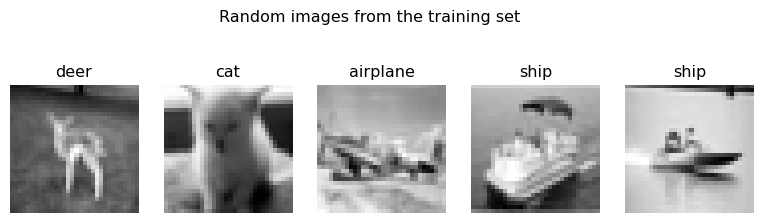

In [4]:
train_loader, val_loader = get_dataloaders(batch_size=128)
class_labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# Draw one batch to show some training images
x, y = next(train_loader.__iter__())

fig, ax = plt.subplots(ncols=5, figsize=(10, 3))
fig.suptitle("Random images from the training set")
for i in range(5):
    ax[i].imshow(x[i].cpu().numpy().transpose(1, 2, 0), cmap="gray")
    ax[i].axis("off")
    ax[i].set_title(class_labels[y[i]])

### Network architecture and training

We begin with a barebones feedforward network architecture with two
hidden layers.

![network_two_hidden_layers.svg](attachment:network_two_hidden_layers.svg)

It computes the function $$ f(x) = \theta \sigma(W_2 \sigma(W_1 x))$$
with: - $x \in \mathbb R^d$ is an input image reshaped as a vector
($d = 32 \times 32$), - $W_1 \in \mathbb R^{n_1 \times d}$ the weights
of the $n_1$ neurons in the first layer, -
$W_2 \in \mathbb R^{n_2 \times n_1}$ the weights of the $n_2$ neurons in
the second layer, - $\theta \in \mathbb R^{c \times n_2}$ the weights of
the classifier, which predicts log-likelihoods for the $c = 10$
classes, - $\sigma$ is a pointwise non-linearity (here a ReLU).

In [5]:
dims = [
    32 * 32,
    512,
    256,
    10,
]  # Sizes of layers, [input dim, hidden dims..., output dim (number of classes)]
model = initialize_mlp_model(dims)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=1024, out_features=512, bias=False)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=256, bias=False)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=10, bias=False)
)

We train the network for 5 *epochs* (passes over the training set). We
measure the average accuracy (frequency at which the network correctly
predicts the correct class). On a held-out validation set, it increases
from 10%, which corresponds to a random guess, to about 43%.

<span class="column-margin">Note: accuracies below 90% are generally
considered low, with state-of-the-art networks reaching 99.5% accuracy.
The accuracy can be increased by switching to a convolutional
architecture (see below), increasing the width and depth of the network,
adding data augmentation, training for a longer time, etc…</span>

In [6]:
train_model(model, train_loader, val_loader, num_epochs=5)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=1024, out_features=512, bias=False)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=256, bias=False)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=10, bias=False)
)

## Analyzing a trained network

### Measuring the dimensionality of hidden representations

At each layer, we can measure the dimensionality of the corresponding
hidden representation with a PCA. We thus compute the covariance of the
representation. Let $\varphi(x)$ denote the representation of the input
$x$ at the given layer, we compute:

$$ \mathbb E_x\left[\varphi(x) \, \varphi(x)^\top\right]. $$

<span class="column-margin">Note: We shall act as if the mean
$\mathbb E_x \left[ \varphi(x) \right]$ was zero for simplicity.
Typically, this is enforced by a normalization layer such as [batch
normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
or [layer
normalization](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).</span>

One might want to compute the hidden representations of all the training
images:

$$ 
\newcommand{\vertbar}{\rule[-1ex]{0.5pt}{2.5ex}}
X = 
\left[
  \begin{array}{cccc}
    \vertbar & \vertbar &        & \vertbar \\
    \varphi(x_1)     & \varphi(x_2)    & \cdots & \varphi(x_n)    \\
    \vertbar & \vertbar &        & \vertbar 
  \end{array}
\right]^\top,
$$

and compute the covariance with $\frac1n X^\top X$. However, this matrix
is usually too big to fit into memory (especially for larger datasets)!

We thus adopt the approach of mini-batching. We break the dataset into
*batches* (little chunks) and load it in memory one batch at a time. The
covariance can then be computed iteratively in this way:

``` python
covariance_accumulator = 0
num_samples = 0
for x in dataloader:                   # x has shape (batch_size, input_dim)
    z = phi(x)                         # z has shape (batch_size, repr_dim)
    covariance_accumulator += z.T @ z  # shape (repr_dim, repr_dim)
    num_samples += z.shape[0]          # We have processed batch_size samples.
covariance = covariance_accumulator / num_samples
```

This “trick” works for the expected value of any function over the data.
The mini-batching and loading into memory is taken care of by PyTorch’s
[`DataLoader`](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)
class. Note that contrary to model training, the batch size here does
not affect the end result, it influences only the time and memory
complexity of the computation. The batch size should be small enough to
fit into memory, but as large as possible to exploit the parallelization
of computation (as done automatically by PyTorch on a GPU backend).

In [7]:
# Layers 3 and 5 correspond to the output of the two ReLUs.
layers = [3, 5]
activation_covariances = compute_activation_covariances(train_loader, layers, model)
# Activation covariances is a list of covariances, one per layer.

Once we have compute the covariance of the hidden representation, we can
diagonalize it to compute its eigenvalues, which encode the variance
along each principal component (we do not concern ourselves with
cross-validation here).

As another way of evaluating the importance of each principal component,
we can perform *clipping*. This consists of inserting an operation in
the middle of the network, which projects the hidden representation on
its first $k$ principal components. We can then evaluate the accuracy of
the network as a function of $k$, which allows measuring the cumulative
“information” stored in the first $k$ PCs.

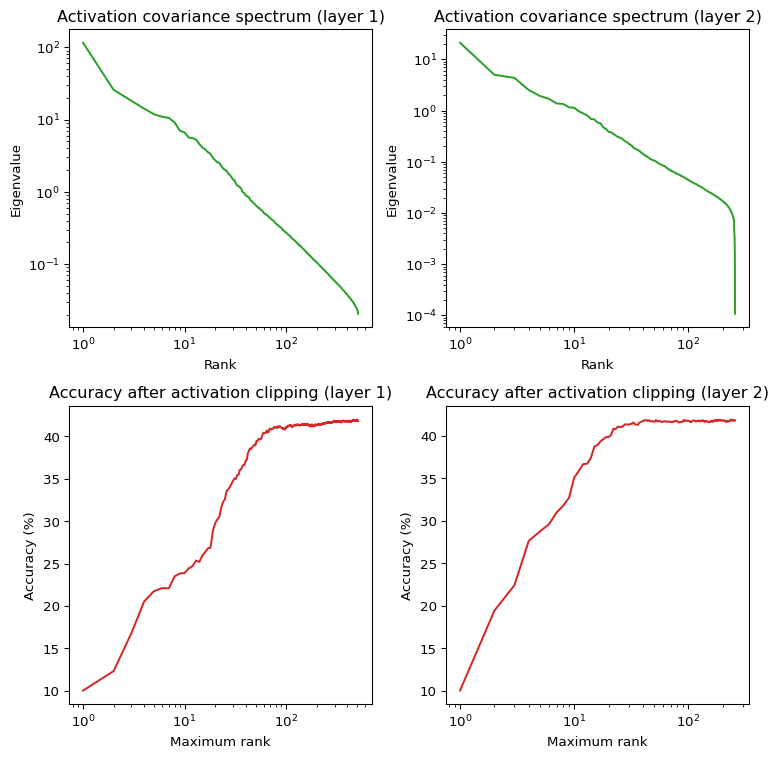

In [8]:
fig, ax = plt.subplots(figsize=(8, 8), nrows=2, ncols=2)

for layer_idx in range(2):
    activation_covariance = activation_covariances[layer_idx]
    activation_eigenvalues, activation_eigenvectors = torch.linalg.eigh(
        activation_covariance
    )
    # (num_eig,), descending order
    activation_eigenvalues = activation_eigenvalues.flip(-1)

    # (num_eig, dim), descending order
    activation_eigenvectors = activation_eigenvectors.flip(-1).T

    # Plot the eigenvalues of the activation covariances.
    plt.sca(ax[0][layer_idx])
    plt.title(f"Activation covariance spectrum (layer {layer_idx + 1})")
    y = activation_eigenvalues.cpu().numpy()
    x = 1 + np.arange(len(y))
    plt.plot(x, y, color="tab:green")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Rank")
    plt.ylabel("Eigenvalue")

    # Clipping analysis.
    dimensions = 1 + np.arange(activation_eigenvectors.shape[1])
    accuracies = clip(
        model, 2 * layer_idx + 3, activation_eigenvectors, dimensions, val_loader
    )

    plt.sca(ax[1][layer_idx])
    plt.plot(dimensions, accuracies, color="tab:red")
    plt.title(f"Accuracy after activation clipping (layer {layer_idx + 1})")
    plt.xlabel("Maximum rank")
    plt.ylabel(r"Accuracy (%)")
    plt.xscale("log")

plt.tight_layout()
plt.show()

We see that the learned representations have a power law spectrum.
Further, they can be somewhat reduced in dimension at little cost in
accuracy (note that rank is in log scale).

### Measuring the dimensionality of neuron weights

Let us focus on the first layer. The weight matrix $W_1$ of size
$n_1 \times d$ contains the weights of the $n_1$ neurons in the first
layer, each being a $d$-dimensional vector. (This also applies to the
other layers. For instance, the second weight matrix $W_2$ of size
$n_2 \times n_1$ contains the weights of the $n_2$ neurons in the second
layer, each being an $n_1$-dimensional vector.)

We can view these neurons as being samples from a continuous
distribution, and then estimate statistical properties (moments) of this
distribution. For instance, assuming a zero mean, we can compute the
covariance of the neuron weights as: $$ C = \frac1{n_1} W_1^\top W_1 $$

![neuron_population_cov_v2.svg](attachment:neuron_population_cov_v2.svg)

The covariance reveals how the global geometry of the representation is
modified by the neuron population. Indeed, the representation computed
by the first layer is $\varphi_1(x) = \sigma(W_1 x)$. Focusing on the
weight matrix $W_1$, we can decompose its effect with a singular value
decomposition: $$ W_1 = U \Sigma V^\top.$$

<img src="attachment:weight_svd.svg" alt="SVD" style="width: 800px;"/>

Recall that the right singular vectors $V$ are also the eigenvectors of
the covariance $C$, while the singular values $\Sigma$ are directly
related to the eigenvalues of the covariance $C$.

This implies that the first layer $\sigma(W_1 x)$ computes the following
steps:

-   an orthogonal change of basis to the PCA basis of the neuron
    weights,
-   a scaling along each principal component (proportional to the square
    root of the covariance eigenvalues),
-   another orthogonal change of basis, which defines the basis in which
    the non-linearity $\sigma$ is applied.

The covariance eigenvalues and eigenvectors thus define how the neural
code globally changes the geometry of its input before the
non-linearity. In particular, if the covariance is low-rank, it
indicates that the representation only depends on a low-dimensional
projection of the input.

To interpret the eigenvalues of the covariance, we can compare their
values after training with their values at initialization. Neuron
weights are initialized from a distribution with covariance identity (in
PyTorch, each component is by default independently drawn from a uniform
distribution). However, the eigenvalues of the *empirical* covariance
computed from only the $n_1$ neurons are not all one but follow the
[Marchenko-Pastur](https://en.wikipedia.org/wiki/Marchenko-Pastur_distribution)
distribution. This comparison allows estimating which eigenvalues are
significantly non-random.

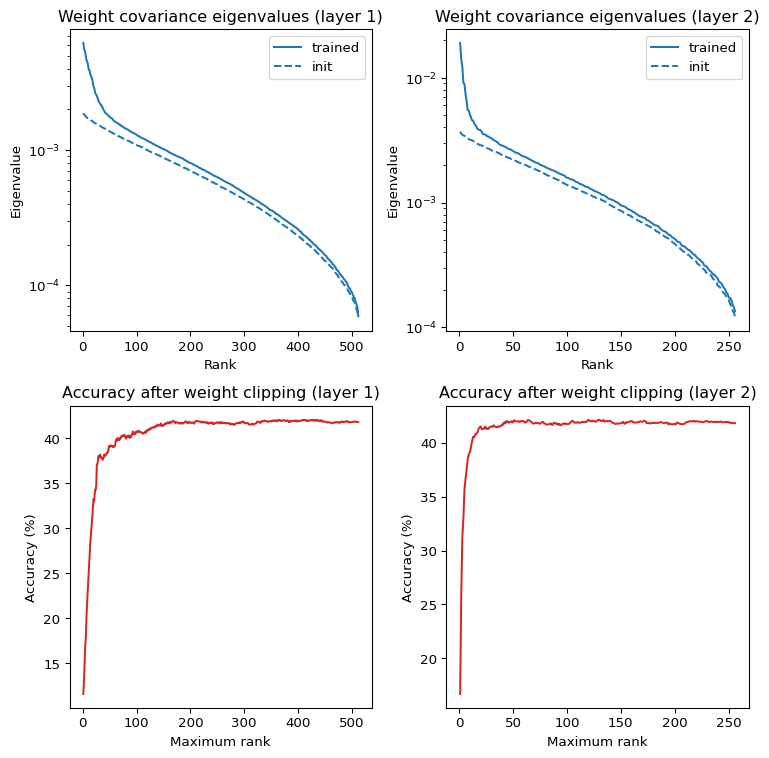

In [9]:
fig, ax = plt.subplots(figsize=(8, 8), nrows=2, ncols=2)

for layer_idx in range(2):
    weight_matrix = model[2 * layer_idx + 1].weight  # (N, D)
    # Compute eigenvalues and eigenvectors of weight covariance efficiently from the SVD.
    _, weight_singular_values, weight_eigenvectors = torch.linalg.svd(
        weight_matrix, full_matrices=False
    )  # (num_eig, dim), descending order
    weight_eigenvalues = weight_singular_values**2 / weight_matrix.shape[0]

    # Compare with eigenvalues at initialization.
    init_weight_matrix = initialize_mlp_model(dims)[2 * layer_idx + 1].weight
    init_eigenvalues = (
        torch.linalg.svdvals(init_weight_matrix) ** 2 / weight_matrix.shape[0]
    )

    # Plot the eigenvalues of the weight covariances.
    plt.sca(ax[0][layer_idx])
    plt.title(f"Weight covariance eigenvalues (layer {layer_idx + 1})")
    y = weight_eigenvalues.cpu().numpy()
    x = 1 + np.arange(len(y))
    plt.plot(x, y, color="tab:blue", label="trained")
    plt.plot(
        x,
        init_eigenvalues.detach().cpu().numpy(),
        linestyle="dashed",
        color="tab:blue",
        label="init",
    )
    plt.yscale("log")
    plt.xlabel("Rank")
    plt.ylabel("Eigenvalue")
    plt.legend(loc="upper right")

    # Clipping analysis.
    dimensions = 1 + np.arange(weight_eigenvectors.shape[0])
    accuracies = clip(
        model, 2 * layer_idx + 1, weight_eigenvectors, dimensions, val_loader
    )

    plt.sca(ax[1][layer_idx])
    plt.plot(dimensions, accuracies, color="tab:red")
    plt.title(f"Accuracy after weight clipping (layer {layer_idx + 1})")
    plt.xlabel("Maximum rank")
    plt.ylabel(r"Accuracy (%)")

plt.tight_layout()
plt.show()

We see that only the largest eigenvalues depart from the
Marchenko-Pastur distribution. At low ranks, the spectrum roughly has an
exponential decay, as evidenced by the straight line in the log-linear
plot (note that rank is in linear scale here to evidence this fact).
This gives an estimation of about 50 learned principal components for
the first layer, and 15 for the second layer. Further, clipping the
neuron weights to these learned principal compoennts incurs a negligible
loss of accuracy.

## Comparing neural networks

Let us a train a second network with the same architecture on the same
dataset but with a different random initialization.

In [10]:
models = [model] + [
    train_model(initialize_mlp_model(dims), train_loader, val_loader, num_epochs=5)
]

This second network reaches the same accuracy as the first one. Has it
arrived at the same solution than the first network?

### Comparing weight and activation covariances

For both networks, we can compute their weight and activation
covariances at each layer. How do we compare them?

A first step is to (visually) compare the eigenvalues of the covariance.

However, this is only a partial comparison. A much stronger comparison
can be obtained by comparing the eigenvectors of the covariance. This is
achieved by computing the orthogonal change of basis from the
eigenvectors for the first network to the eigenvectors for the second
network. This is a matrix that we can visualize. If it is close to the
identity, then the two sets of eigenvectors are almost the same. On the
other hand, if the eigenvectors are really different, then no entry of
this matrix will be close to unity.

<span class="column-margin">Note: The eigenvectors of a matrix are
determined up to a reverse in direction. This means that $v$ and $-v$
correspond to the same eigenvector. To this end, to compare two sets of
eigenvectors, we look at the absolute values of the entries of the
change of basis matrix.</span>

In [11]:
model_layer_covs = [activation_covariances] + [
    compute_activation_covariances(train_loader, layers, models[1])
]

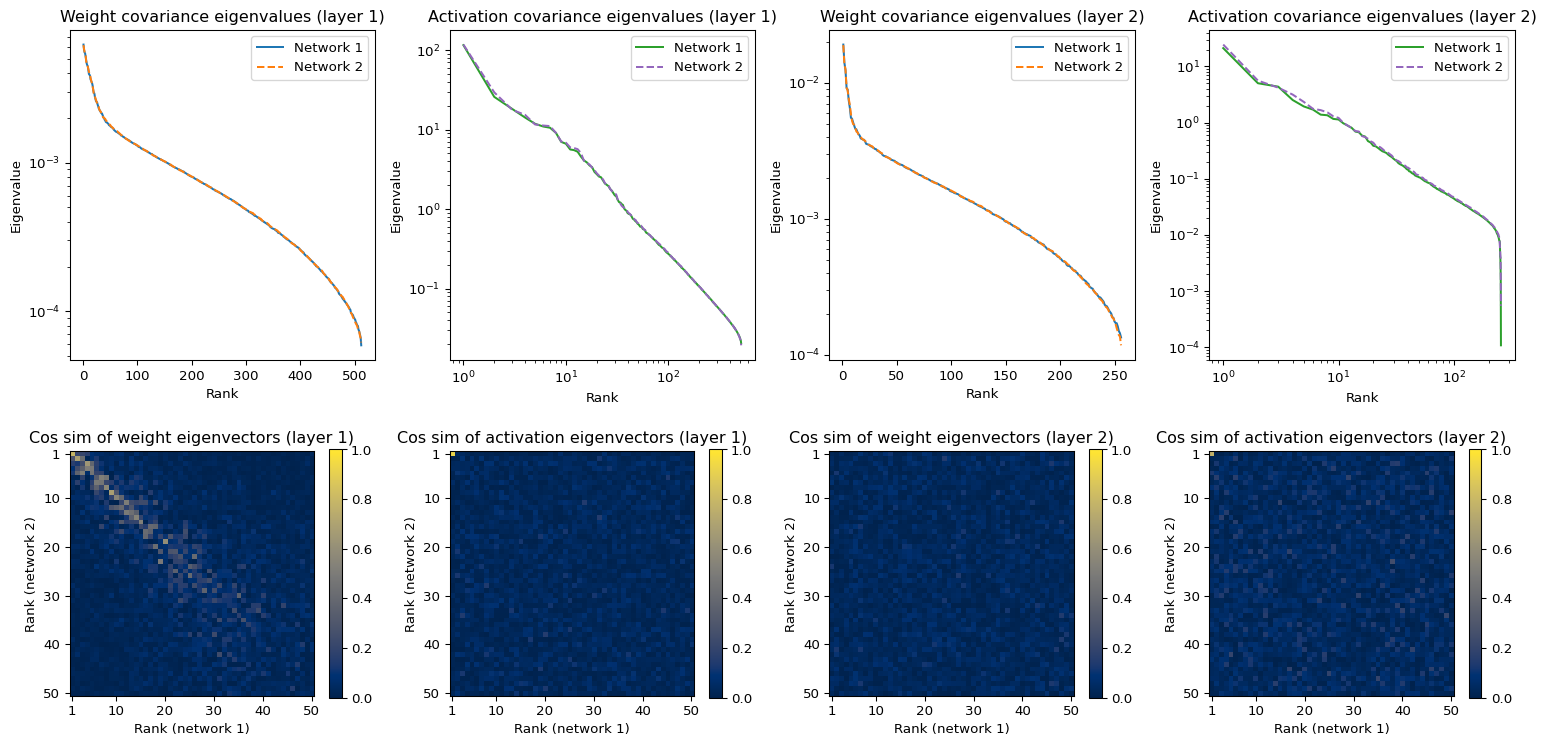

In [12]:
fig, ax = plt.subplots(figsize=(16, 8), nrows=2, ncols=4)

for j in range(2):
    # Compute weight spectrum and eigenvectors for each model.
    weight_spectra = []
    weight_eigenvectors = []
    for model in models:
        w = model[2 * j + 1].weight  # (N, D)
        u, s, vh = torch.linalg.svd(w, full_matrices=False)  # (N, R), (R,), (R, D)
        spectrum = s**2 / w.shape[0]
        weight_spectra.append(spectrum)
        weight_eigenvectors.append(vh)

    # Compare weights spectra (stable).
    plt.sca(ax[0][2 * j])
    plt.title(f"Weight covariance eigenvalues (layer {j + 1})")
    for i, spectrum in enumerate(weight_spectra):
        y = spectrum.cpu().numpy()
        x = 1 + np.arange(len(y))
        plt.plot(
            x,
            y,
            color=["tab:blue", "tab:orange"][i],
            linestyle=["solid", "dashed"][i],
            label=f"Network {i + 1}",
        )
    plt.yscale("log")
    plt.xlabel("Rank")
    plt.ylabel("Eigenvalue")
    plt.legend(loc="upper right")

    # Compare weight eigenvectors (unstable after first layer because no alignment).
    plt.sca(ax[1][2 * j])
    stab = torch.abs(weight_eigenvectors[0] @ weight_eigenvectors[1].T)  # (R, R)
    plt.imshow(stab.T.cpu().numpy()[:50, :50], cmap="cividis", vmin=0, vmax=1)
    plt.colorbar(shrink=0.75)
    plt.title(f"Cos sim of weight eigenvectors (layer {j + 1})")
    plt.xlabel("Rank (network 1)")
    plt.ylabel("Rank (network 2)")
    ticks = np.asarray([1, 10, 20, 30, 40, 50])
    plt.xticks(ticks=ticks - 1, labels=[str(i) for i in ticks])
    plt.yticks(ticks=ticks - 1, labels=[str(i) for i in ticks])

    # Compute activations spectrum and eigenvectors for each model.
    activation_spectra = []
    activation_eigenvectors = []
    for layer_covs in model_layer_covs:
        cov = layer_covs[j]  # (C, C)
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)
        # Sort in descending order and transpose.
        eigenvalues, eigenvectors = eigenvalues.flip(-1), eigenvectors.flip(-1)
        eigenvectors = eigenvectors.T  # (R, D)
        activation_spectra.append(eigenvalues)
        activation_eigenvectors.append(eigenvectors)

    # Compare activation spectra (stable).
    plt.sca(ax[0][2 * j + 1])
    plt.title(f"Activation covariance eigenvalues (layer {j + 1})")
    for i, spectrum in enumerate(activation_spectra):
        y = spectrum.cpu().numpy()
        x = 1 + np.arange(len(y))
        plt.plot(
            x,
            y,
            color=["tab:green", "tab:purple"][i],
            linestyle=["solid", "dashed"][i],
            label=f"Network {i + 1}",
        )
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Rank")
    plt.ylabel("Eigenvalue")
    plt.legend(loc="upper right")

    # Compare activation eigenvectors (unstable because no alignment)
    plt.sca(ax[1][2 * j + 1])
    stab = torch.abs(
        activation_eigenvectors[0] @ activation_eigenvectors[1].T
    )  # (R, R)
    plt.imshow(stab.T.cpu().numpy()[:50, :50], cmap="cividis", vmin=0, vmax=1)
    plt.colorbar(shrink=0.75)
    plt.title(f"Cos sim of activation eigenvectors (layer {j + 1})")
    plt.xlabel("Rank (network 1)")
    plt.ylabel("Rank (network 2)")
    ticks = np.asarray([1, 10, 20, 30, 40, 50])
    plt.xticks(ticks=ticks - 1, labels=[str(i) for i in ticks])
    plt.yticks(ticks=ticks - 1, labels=[str(i) for i in ticks])

plt.tight_layout()
plt.show()

Weight and activation spectra are the same across random initialization.
However, eigenvectors are not the same except for the first layer
weights. The reason is that deeper eigenvectors depend on the particular
individual neurons of the first layer, not just their population
statistics. Network alignment is needed to take that into account.

### Aligning two networks together

The similarity between activation covariance eigenvalues suggests that
the representations learned by the two networks might have shared latent
dimensions. The dissimilarity between the activation covariance
eigenvectors show that these latent dimensions are expressed in
different bases.

The two networks can be *aligned* together with PLS-SVD
(hyper-alignment). Given representations $\varphi(x)$ and $\psi(x)$ for
the two networks, it computes the best orthogonal alignment matrix $A$
that aligns $\varphi$ to $\psi$:
$$ \min_A \mathbb E_x[\|A\varphi(x) - \psi(x)\|^2] \quad\text{such that}\quad A^\top A = I_d $$

This is akin to a linear regression, but additionally imposes that $A$
is orthogonal in order to preserve the geometry of the latent
dimensions.

The optimal alignment $A$ can be computed explicitly from an SVD of the
cross-covariance matrix:
$$ A = U V^\top \quad\text{with}\quad \mathbb E_x[\psi(x)\varphi(x)^\top] = U\Sigma V^\top$$

![image.png](attachment:image.png)

![image-2.png](attachment:image-2.png)

The magnitude of the singular values $\Sigma$ indicate the amount of
variance that is explained by the alignment $A$. Indeed, the unexplained
variance (the residual error) can be written as:
$$ \mathbb E_x[\|A\varphi(x) - \psi(x)\|^2] = \mathbb E_x[\|\varphi(x)\|^2] + \mathbb E_x[\|\psi(x)\|^2] - 2 \,\mathrm{tr}\ \Sigma $$

To evaluate the effectiveness of the alignment procedure, we can thus
compute an $r^2$ measure as the ratio between the explained variance and
the total variance:
$$ r^2 = \frac{\mathrm{tr}\ \Sigma}{\sqrt{\mathbb E_x[\|\varphi(x)\|^2]}\sqrt{\mathbb E_x[\|\psi(x)\|^2]}} $$

In [13]:
model1, model2 = models
cross_covs = compute_activation_covariances(train_loader, layers, model1, model2)
# cross_covs is a list of activation covariances (C1, C2) for each layer.

In [14]:
aligns = []  # layer_idx -> alignment
for j in range(2):
    cross_cov = cross_covs[j]
    u, s, vh = torch.linalg.svd(cross_cov, full_matrices=False)

    explained_variance = torch.sum(s)
    total_variance = torch.sqrt(
        torch.trace(model_layer_covs[0][j]) * torch.trace(model_layer_covs[1][j])
    )
    r_squared = explained_variance / total_variance
    print(
        f"Layer {j + 1}: {100 * r_squared.item():.1f}% of variance explained by"
        " alignment"
    )
    # NOTE: r² should be computed on a test set to control for overfitting.

    align = u @ vh
    aligns.append(align)

Layer 1: 92.1% of variance explained by alignment
Layer 2: 86.6% of variance explained by alignment

We see that the alignment procedure is able to explain a good fraction
of the variance of the representations.

### Using aligned networks to compare weight and activation eigenvectors

Let us now use the alignment matrix $A$ to meaningfully compare weight
and activation eigenvectors.

The rule of thumb is to *always compare eigenvectors that apply on the
same representation*. Consider two networks, with respective hidden
representations $\varphi(x)$ and $\psi(x)$. These two representations
share their latent dimensions, as evidenced by the fact that
$A\varphi(x) \approx \psi(x)$.

Assume that we have an activation eigenvector $u$ for the first network,
and another activation eigenvector $v$ for the second network, which may
or may not encode the same latent dimension. How do we compare them?
Because $A\varphi(x) \approx \psi(x)$, we should compare $Au$ with $v$.

Similarly, suppose that $u$ and $v$ are now weight eigenvectors
respectively for the first and second network. The weight eigenvector
$u$ applies on the representation $\varphi(x)$, computing
$\langle u, \varphi(x) \rangle$, while the weight eigenvector $v$
applies on the the representation $\psi(x)$, computing
$\langle v, \psi(x) \rangle$. We then have
$$ \langle u, \varphi(x) \rangle = \langle Au, A\varphi(x) \rangle \approx \langle Au, \psi(x) \rangle, $$
which again means that we should compare $Au$ with $v$.

![image.png](attachment:image.png)

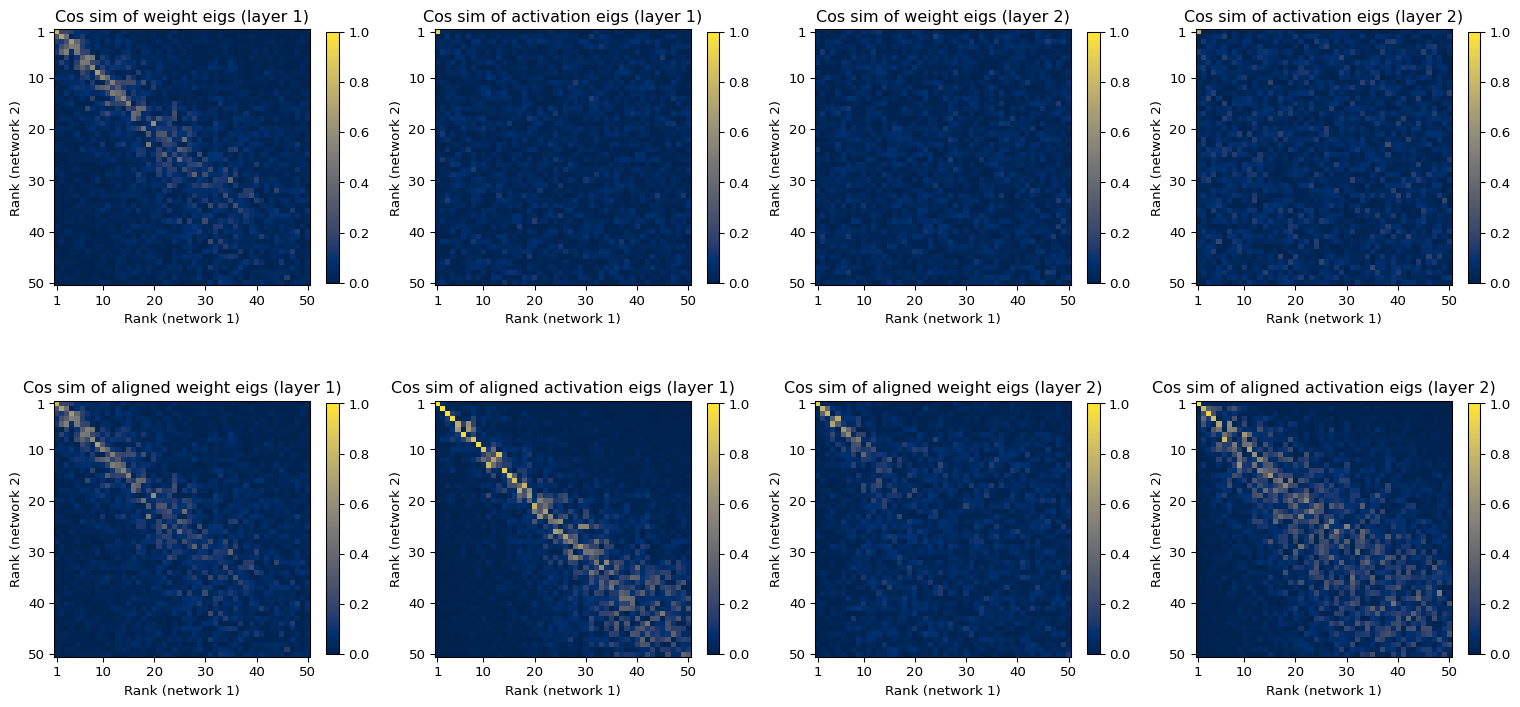

In [15]:
fig, ax = plt.subplots(figsize=(16, 8), nrows=2, ncols=4)

for j in range(2):
    # Compute weight eigenvectors for each model.
    weight_eigenvectors = []
    for model in models:
        w = model[2 * j + 1].weight  # (N, D)
        u, s, vh = torch.linalg.svd(w, full_matrices=False)  # (N, R), (R,), (R, D)
        weight_eigenvectors.append(vh)

    # Compute activations eigenvectors for each model.
    activation_eigenvectors = []
    for layer_covs in model_layer_covs:
        cov = layer_covs[j]  # (C, C)
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)
        # Sort in descending order and transpose.
        eigenvalues, eigenvectors = eigenvalues.flip(-1), eigenvectors.flip(-1)
        eigenvectors = eigenvectors.T  # (R, D)
        activation_eigenvectors.append(eigenvectors)

    for quantity, eigenvectors in dict(
        weight=weight_eigenvectors, activation=activation_eigenvectors
    ).items():
        for aligned in [False, True]:
            # Compute stability, with alignment if needed.
            if aligned and not (quantity == "weight" and j == 0):
                align = aligns[dict(weight=j - 1, activation=j)[quantity]]
                stab = torch.abs(eigenvectors[0] @ align @ eigenvectors[1].T)  # (R, R)
            else:
                stab = torch.abs(eigenvectors[0] @ eigenvectors[1].T)  # (R, R)

            # Plot stability of eigenvectors.
            plt.sca(ax[int(aligned)][2 * j + dict(weight=0, activation=1)[quantity]])
            plt.imshow(stab.T.cpu().numpy()[:50, :50], cmap="cividis", vmin=0, vmax=1)
            plt.colorbar(shrink=0.7)
            plt.title(
                f"Cos sim of {'aligned ' if aligned else ''}{quantity} eigs (layer"
                f" {j + 1})"
            )
            plt.xlabel("Rank (network 1)")
            plt.ylabel("Rank (network 2)")
            ticks = np.asarray([1, 10, 20, 30, 40, 50])
            plt.xticks(ticks=ticks - 1, labels=[str(i) for i in ticks])
            plt.yticks(ticks=ticks - 1, labels=[str(i) for i in ticks])

plt.tight_layout()
plt.show()

After alignment, top eigenvectors strongly correlate across random
initializations. We have seen that it is exactly these eigenvectors
which matter for performance. The informative, learned weight and
activation principal components are thus shared by both networks: they
are universal!

### Generating a new network without training

### Generating a new network without training

Do the covariances really encode all the information needed to explain
the performance of the network?

We can check by generating *new, random weights* which have the same
covariance as that of a trained network. This is done by drawing the
weights of each neuron independently from a Gaussian distribution.
*Note: the generated network should be aligned to the original network
in order to use the same weight covariances.*

The generation is iterative, layer by layer: - Draw samples from
$\mathcal N\left(0, \frac 1{n_1} W_1^{\rm T} W_1\right)$ for the weights
$W_1'$ of the first layer - Compute the alignment $A_1$ so that
$A_1 \sigma(W_1'x) \approx \sigma(W_1 x)$ - Draw samples from
$\mathcal N\left(0, \frac 1{n_2} (W_2 A_1)^{\rm T} (W_2 A_1)\right)$ for
the weights $W_2'$ of the second layer - Compute the alignment $A_2$ so
that
$A_2 \sigma(W_2' \sigma(W_1' x)) \approx \sigma(W_2 \sigma(W_1 x))$ -
Set the classifier weights $\theta' = \theta A_2$

In [16]:
state_dict_keys = list(model.state_dict().keys())
print(f"Generating {state_dict_keys}")
reference_accuracy, generated_accuracy = generate_network(
    model, state_dict_keys, train_loader, val_loader
)
print(
    f"Accuracy after sampling: {generated_accuracy:.1f}% (accuracy after training:"
    f" {reference_accuracy:.1f}%)"
)

Generating ['1.weight', '3.weight', '5.weight']
Accuracy after sampling: 30.9% (accuracy after training: 42.0%)

Without any training, the generated network recovers a good fraction of
the performance of the trained network. It implies that the covariances
indeed encode most of the task-relevant information learned during
training.

### Extending the analysis to convolutional networks

We now consider a CNN, composed of two $5 \times 5$ convolutional layers
and a fully-connected classifier.

![cnn_two_hidden_layers.svg](attachment:cnn_two_hidden_layers.svg)

In [17]:
channels = [1, 32, 64]
cnn_model = initialize_cnn_model(channels)
print(cnn_model)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), bias=False)
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1600, out_features=10, bias=False)
)

In [18]:
train_model(cnn_model, train_loader, val_loader, num_epochs=5)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), bias=False)
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1600, out_features=10, bias=False)
)

In CNNs, the weights are no longer matrices but fourth-order tensors, of
shape $C_{\rm out} \times C_{\rm in} \times k_{\rm h} \times k_{\rm w}$.
This corresponds to $n = C_{\rm out}$ neurons which compute linear
projections over patches, of dimension
$d = C_{\rm out} \times k_{\rm h} \times k_{\rm w}$. We can thus reshape
the weight tensor as a $n_1 \times d$ matrix $W_1$, and treat it as the
weight matrix of a fully-connected network as above. We can thus compute
the weight covariance for the first layer as
$\frac1{n_1} W_1^{\rm T} W_1$, which is a $d \times d$ matrix.

``` python
weight = conv_layer.weight  # (C_out, C_in, k_h, k_w)
weight_flat = weight.reshape((weight.shape[0], -1))  # (C_out, C_in*k_h*k_w)
weight_cov = weight_flat.T @ weight_flat / weight_flat.shape[0]  # (C_in*k_h*k_w, C_in*k_h*k_w)
```

Similarly, the activations are no longer vectors but third-order
tensors, of shape $C \times H \times W$. *Rather than reshaping them as
vectors, we will only compute covariances over channels and treat the
spatial dimensions as additional samples.* This means we will align the
channels of two representations, but not their spatial dimensions. This
is due to the translation-equivariance of CNNs, which preserve the
spatial dimensions. The arbitrariness of the neural code is thus only
along the channel dimension.

``` python
activations = (
    phi(x)  # (B, C, H, W)
    .permute(0, 2, 3, 1)  # (B, H, W, C)
    .flatten(start_dim=0, end_dim=2)  # (BHW, C)
)
activations_cov = activations.T @ activations / activations.shape[0]  # (C, C)
```

In [19]:
state_dict_keys = list(cnn_model.state_dict().keys())
print(f"Generating {state_dict_keys}")
reference_accuracy, generated_accuracy = generate_network(
    cnn_model, state_dict_keys, train_loader, val_loader
)
print(
    f"Accuracy after sampling: {generated_accuracy:.1f}% (accuracy after training:"
    f" {reference_accuracy:.1f}%)"
)

Generating ['0.weight', '2.weight', '5.weight']
Accuracy after sampling: 37.7% (accuracy after training: 57.5%)

About two thirds of the performance of the trained network is captured
in its covariances. Generating CNN weights with Gaussian distributions
does not work as well because the spatial filters are not
well-approximated by a Gaussian (due to selectivity in orientation and
frequency).

The accuracy of the generation procedure can be improved by switching to
an architecture which predefines the spatial filters, so that they are
not learned nor randomly generated. This is achieved by *learned*
scattering networks, which use wavelet spatial filters and learned
weights along channels. See <https://arxiv.org/abs/2110.05283>.